In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from bs4 import element
import spacy
nlp = spacy.load("en_core_web_sm")

import numpy as np
import networkx as nx
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure, from_networkx
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)

import matplotlib.pyplot as plt
from bokeh.plotting import show, ColumnDataSource
from bokeh.models import LabelSet

output_notebook()

from spacy.matcher import Matcher 
from spacy.tokens import Span 

def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

Loading BokehJS ...

In [2]:
excel_path = 'ROWLING_harrypotterandthephilosophersstone_1997.xlsx'
xml = 'ROWLING_harrypotterandthephilosophersstone_1997.xml'

In [3]:
characters = pd.read_excel(excel_path, index_col=0)

In [4]:
characters.to_csv('character.csv')

In [5]:
characters['full name']['harry1']

'Harry Potter'

In [86]:
with open(xml,'r') as f:
    soup = BeautifulSoup(f)

c_list = characters.index.to_list()
pairs = []

for c in c_list:
    refs = soup.find_all(attrs={'ref':c})
    for r in refs:
        r_id = r.attrs['ref']
        sent = list(r.next_siblings)
        _sent = str(r.text)
        
        for chunk in sent:
            _sent += str(chunk)
            try:
                if chunk.attrs['ref'] != r_id:
                    relation = get_relation(_sent)
            except (KeyError, AttributeError):
                pass
            
            if type(chunk) == element.NavigableString:
                doc = nlp(str(chunk))
                for w in doc:
                    if (w.dep_ == 'ROOT') and (w.lemma_ != '–'):
                        relation = True
                        break
                    else:
                        relation = False
            if relation and type(chunk) == element.Tag:
                try:
                    if chunk.attrs['ref'] != r_id:
                        pairs.append([r_id,w.lemma_,chunk.attrs['ref']])
                except KeyError:
                    pass

In [7]:
# df = pd.DataFrame(pairs)
# df.to_csv('relations.csv')
df = pd.read_csv('relations.csv', index_col=0)
df.columns = ['source','edge', 'target']

In [8]:
def get_full_name(id_):
    lookup = lambda id_ : characters['full name'][id_]
    try:
        return lookup(id_)
    except KeyError:
        return np.nan

df['source_name'] = df.source.apply(get_full_name)
df['target_name'] = df.target.apply(get_full_name)

In [9]:
df.head()

,source,edge,target,source_name,target_name
0,adrian13,way,fred13,Adrian Pucey,Fred Weasley
1,adrian13,or,george13,Adrian Pucey,George Weasley
2,adrian13,tell,angelina14,Adrian Pucey,Angelina Johnson
3,adrian13,back,angelina14,Adrian Pucey,Angelina Johnson
4,adrian13,go,angelina14,Adrian Pucey,Angelina Johnson


In [10]:
_df = pd.DataFrame(df[['source_name','edge','target_name']].dropna().groupby(['source_name','target_name','edge']).agg(len).to_frame().to_records())

In [67]:
_df.to_csv('dense_relations.csv')

In [93]:
# create a directed-graph from a dataframe
sample = _df.loc[(_df.edge == 'hate')]
G=nx.from_pandas_edgelist(sample, "source_name", "target_name", 
                          edge_attr=True)

In [94]:
# plt.figure(figsize=(12,12))

# pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()
plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1),
              tools="")
graph = from_networkx(G, nx.spring_layout, scale=0.5, center=(0,0))

# Add some new columns to the node renderer data source
graph.node_renderer.data_source.data['edge'] = sample.edge.to_list()
# graph.node_renderer.data_source.data['colors'] = Category20_20
# graph.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
# graph.node_renderer.glyph.properties_with_values()

plot.renderers.append(graph)

x, y = zip(*graph.layout_provider.graph_layout.values())
data = {'x': list(x), 'y': list(y), 'edge': sample.source_name.to_list()}
labels = LabelSet(
            x='x',
            y='y',
            text='edge',
            source=ColumnDataSource(data))

node_hover_tool = HoverTool(tooltips=[("index", "@index"),("edge", "@edge")])
plot.add_tools(node_hover_tool,BoxZoomTool(), ResetTool())
plot.renderers.append(labels)
show(plot)

In [95]:
# create a directed-graph from a dataframe
sample = _df.loc[(_df.edge == 'fly')]
G=nx.from_pandas_edgelist(sample, "source_name", "target_name", 
                          edge_attr=True)

plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1),
              tools="")
graph = from_networkx(G, nx.spring_layout, scale=0.5, center=(0,0))

graph.node_renderer.data_source.data['edge'] = sample.edge.to_list()

plot.renderers.append(graph)

x, y = zip(*graph.layout_provider.graph_layout.values())
data = {'x': list(x), 'y': list(y), 'edge': sample.source_name.to_list()}
labels = LabelSet(
            x='x',
            y='y',
            text='edge',
            source=ColumnDataSource(data))

node_hover_tool = HoverTool(tooltips=[("index", "@index"),("edge", "@edge")])
plot.add_tools(node_hover_tool,BoxZoomTool(), ResetTool())

plot.renderers.append(labels)
show(plot)

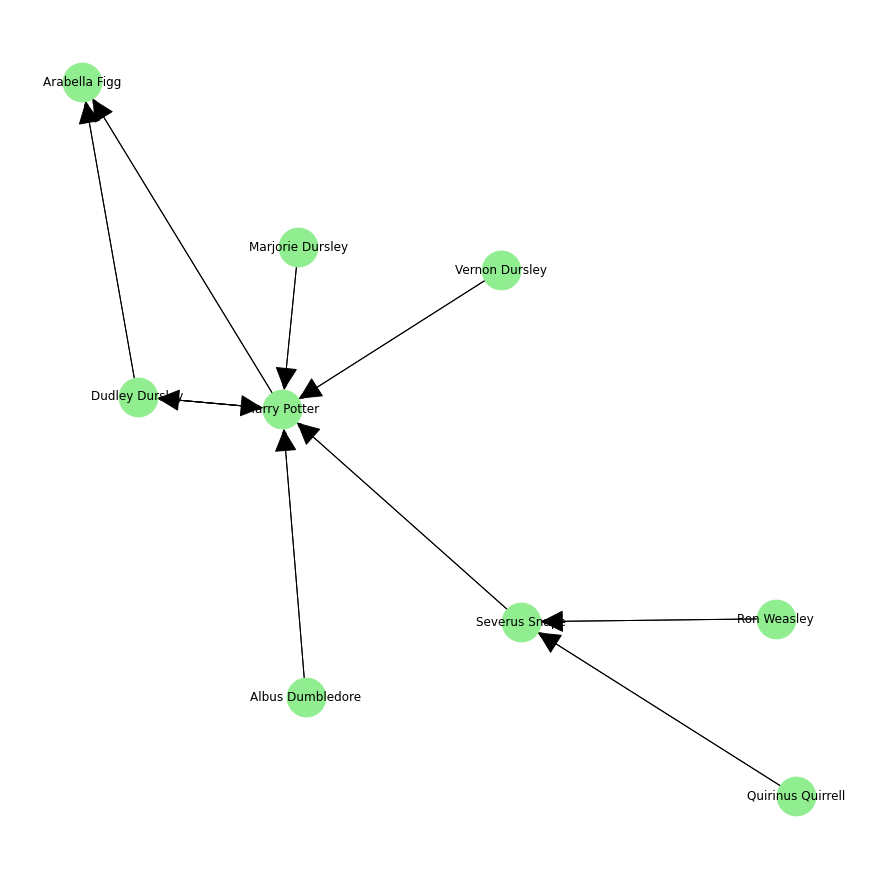

In [53]:
G=nx.from_pandas_edgelist(_df[_df['edge']=="hate"], "source_name", "target_name", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edges(G, pos=pos, arrowsize=50, min_target_margin=20)
plt.show()

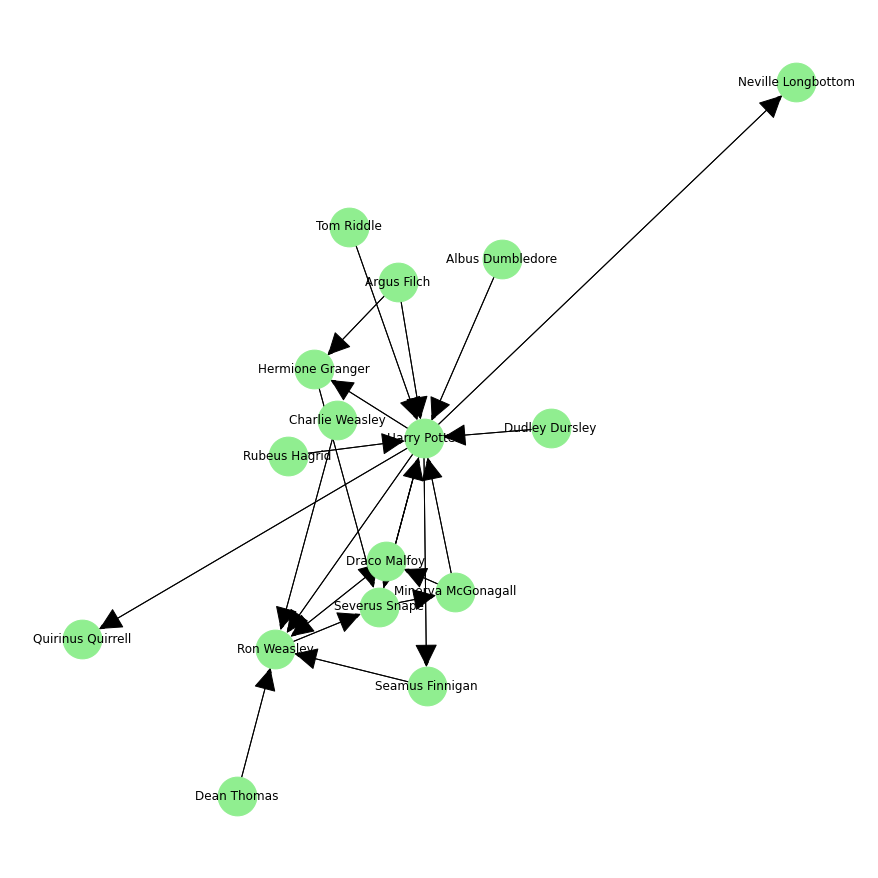

In [97]:
G=nx.from_pandas_edgelist(_df[_df['edge']=="catch"], "source_name", "target_name", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edges(G, pos=pos, arrowsize=50, min_target_margin=20)
plt.show()

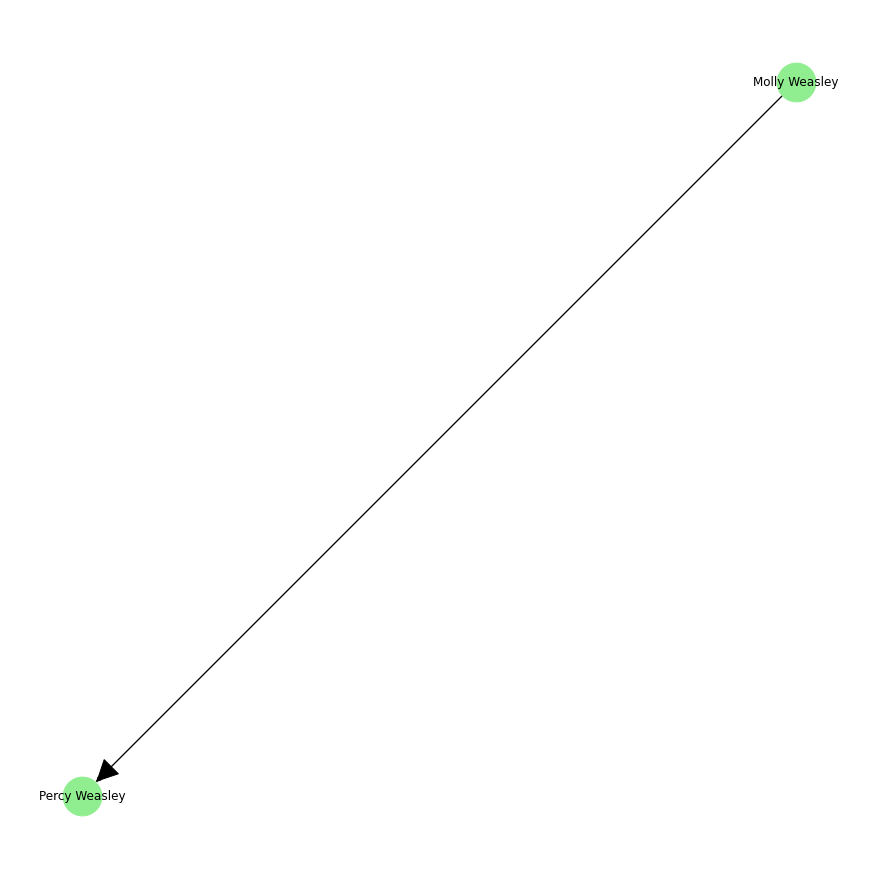

In [98]:
G=nx.from_pandas_edgelist(_df[_df['edge']=="kiss"], "source_name", "target_name", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edges(G, pos=pos, arrowsize=50, min_target_margin=20)
plt.show()

In [118]:
import sklearn
from sklearn import preprocessing
# KMeans clustering a kind of clustering.
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer


from spacy.lang.en import English
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [123]:
text = df[['source','edge','target']].apply(lambda x : ' '.join(x.to_list()) , axis =1).to_list()

In [130]:
df['text'] = text

In [125]:
# We have to use these other parameters because I SAID SO
vec = TfidfVectorizer(tokenizer=tokenizer,
#                       stop_words='english',
                      use_idf=True)
matrix = vec.fit_transform(text)
idf_df = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())

,adrian13,adrian13,adrian13,adrian13,adrian13,adrian13,adrian13,adrian13,adrian13,adrian13,...,george13,george13,george13,george13,fred13,fred13,george13,george13,george13,george13
0,0.57735,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.57735,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.00000,0.57735,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.00000,0.00000,0.57735,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.00000,0.00000,0.00000,0.57735,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21450,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21451,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21452,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21453,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
number_of_clusters=20
km = KMeans(n_clusters=number_of_clusters)

km.fit(matrix)

KMeans(n_clusters=20)

In [134]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
cluster_map = {}
for i in range(number_of_clusters):
    top_ten_words = [str(terms[ind]) for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))
    cluster_map[i] = ' '.join(top_ten_words) 

Top terms per cluster:
Cluster 0: adrian13 work like lesson with
Cluster 1: with harry11 voldemort65 george13 give
Cluster 2: match snape32 teamgryffindor give seem
Cluster 3: teachers fred14 hope . seem
Cluster 4: harry11 ollivander wand and give
Cluster 5: bank grunnings harrychild wand be
Cluster 6: dumbledore100 mean petunia20s vernon20s give
Cluster 7: firstyears ask quirrellearly shoulder hear
Cluster 8:    dudleychild petuniaearly george13 hear
Cluster 9: ron11 chess hermione12 george13 time
Cluster 10: harry11 hagrid62 and hear give
Cluster 11: marcus15 fall harry11 george13 give
Cluster 12: come dudley11 harry10 george13 time
Cluster 13: peeves slam mcgonagall and hear
Cluster 14: draco11 be harry11 . shoulder
Cluster 15: harrychild petunia fer george13 time
Cluster 16: piers11 lean dudley11 harry10 george13
Cluster 17: shred petunia30s harry10 . hear
Cluster 18: harry11 snape31 filch notice time
Cluster 19: harry10 go dudley11 george13 time


In [135]:
df['cluster'] = km.labels_
df['cluster_words'] = df.cluster.apply(lambda x : cluster_map[x])

In [52]:
_df.head()

,source_name,target_name,edge,0
0,Adrian Pucey,Angelina Johnson,back,3
1,Adrian Pucey,Angelina Johnson,dodge,3
2,Adrian Pucey,Angelina Johnson,go,3
3,Adrian Pucey,Angelina Johnson,tell,3
4,Adrian Pucey,Fred Weasley,way,3


In [61]:
# G=nx.from_pandas_edgelist(_df.rename(columns={'source_name':'source','target_name':'target'}), "source", "target", edge_attr=True, create_using=nx.MultiGraph())
G = nx.Graph(name='G')
edges = []
for i in _df.index:
    x = _df.loc[i].source_name
    y = _df.loc[i].target_name
    G.add_node(x, name=x)
    G.add_node(y, name=y)
    edges.append([x,y])
    
G.add_edges_from(edges), 

A = np.array(nx.attr_matrix(G, node_attr='name')[0])
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X,axis=1)

print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)

In [64]:
len(edges)

5774

In [66]:
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])